При выполнении данного проекта было использовано расширение - Nbextensions

# Открытие файлов и изучение общей информации.

**Импортируем нужные библиотеки**

In [1]:
import pandas as pd
import numpy as np
import math
from scipy import stats as st

**Читаем файлы с данными**

In [2]:
messages = pd.read_csv('messages.csv')
calls = pd.read_csv('calls.csv')
internet = pd.read_csv('internet.csv')
users = pd.read_csv('users.csv')
tariffs = pd.read_csv('tariffs.csv')

In [3]:
messages.head()

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


In [4]:
tariffs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   messages_included      2 non-null      int64 
 1   mb_per_month_included  2 non-null      int64 
 2   minutes_included       2 non-null      int64 
 3   rub_monthly_fee        2 non-null      int64 
 4   rub_per_gb             2 non-null      int64 
 5   rub_per_message        2 non-null      int64 
 6   rub_per_minute         2 non-null      int64 
 7   tariff_name            2 non-null      object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


In [5]:
calls.describe()

,duration,user_id
count,202607.000000,202607.000000
mean,6.755887,1253.940619
std,5.843365,144.722751
min,0.000000,1000.000000
25%,1.300000,1126.000000
50%,6.000000,1260.000000
75%,10.700000,1379.000000
max,38.000000,1499.000000


**Вывод**

Импортированы нужные библиотеки. Также, данные были прочитаны и записаны в переменные. Объединять на данном этапе не стал.

# Предобработка данных.

## Преобразование данных, удаление выбросов.

**Преобразуем столбец 'mb_used' к типу int.**
**Округлим значения потраченны минут в разговоре**

In [6]:
internet['mb_used'] = internet['mb_used'].astype('int')
calls['duration'] = calls['duration'].apply(math.ceil)

In [7]:
def to_datetime(df_column):
    df_column = pd.to_datetime(df_column, format = '%Y-%m-%d')
    return df_column

In [8]:
to_datetime(messages['message_date'])
to_datetime(calls['call_date'])
to_datetime(internet['session_date'])
to_datetime(users['churn_date'])
to_datetime(users['reg_date'])

0     2018-05-25
1     2018-11-01
2     2018-06-17
3     2018-08-17
4     2018-05-14
         ...    
495   2018-08-28
496   2018-01-27
497   2018-10-09
498   2018-07-19
499   2018-09-27
Name: reg_date, Length: 500, dtype: datetime64[ns]

**Меняем тип данных в столбцах с датами**

In [9]:
users['reg_date'] = pd.to_datetime(users['reg_date'], format = '%Y-%m-%d')
users['churn_date'] = pd.to_datetime(users['churn_date'], format = '%Y-%m-%d')
internet['session_date'] = pd.to_datetime(internet['session_date'], format = '%Y-%m-%d')
calls['call_date'] = pd.to_datetime(calls['call_date'], format = '%Y-%m-%d')
messages['message_date'] = pd.to_datetime(messages['message_date'], format = '%Y-%m-%d')

**Рассматриваем значения столбца 'duration'**

In [10]:
calls['duration'].value_counts().head(2)

0    39613
7    11510
Name: duration, dtype: int64

In [11]:
calls.query('duration == 0')['duration'].count() / calls['duration'].count()

0.19551644316336553

Звонки, продолжителдьностью 0 секунд составляют 20 % от всех звонком, что достаточно много. Поскольку звонки с продолжительностью 0 не влияют на использование минут пакета, а так же не влияют на доход по определенному пользователю, имеет смысл удалить звонки, продолжительность которых 0 секунд. Так как это может повлиять на анализ, если потребуется работать с количеством звонков. Также, стоит задать вопрос отделу, который собирал данные, может они объяснят наличие таких звонков. Может быть, эта информация будет им полезна.

In [12]:
calls = calls.query('duration > 0')

**Создаем сводную таблицу, в которой у каждого пользователя сгруппировано количество потраченных минут по месяцам**

In [13]:
calls['month'] = calls['call_date'].dt.month
calls

,id,call_date,duration,user_id,month
2,1000_2,2018-06-11,3,1000,6
3,1000_3,2018-09-21,14,1000,9
4,1000_4,2018-12-15,6,1000,12
7,1000_7,2018-08-22,19,1000,8
8,1000_8,2018-09-15,19,1000,9
...,...,...,...,...,...
202602,1499_215,2018-12-26,1,1499,12
202603,1499_216,2018-10-18,19,1499,10
202604,1499_217,2018-11-10,11,1499,11
202605,1499_218,2018-10-06,5,1499,10


In [14]:
user_calls = calls.groupby(['user_id', 'month'])\
                  .agg({'duration':'sum', 'id':'count'})\
                  .reset_index()\
                  .rename(columns={'id': 'calls_id'})

**Создаем сводную таблицу, в которой у каждого пользователя сгруппировано количество потраченных сообщений по месяцам**

In [15]:
messages['month'] = messages['message_date'].dt.month

In [16]:
user_messages = messages.groupby(['user_id', 'month'])\
                        .agg({'id':'count'})\
                        .reset_index()\
                        .rename(columns={'id': 'messages_id'})
user_messages

,user_id,month,messages_id
0,1000,5,22
1,1000,6,60
2,1000,7,75
3,1000,8,81
4,1000,9,57
...,...,...,...
2712,1498,10,42
2713,1499,9,11
2714,1499,10,48
2715,1499,11,59


**Создаем сводную таблицу, в которой у каждого пользователя сгруппировано количество потраченных мегабайтов по месяцам**

In [17]:
internet['month'] = internet['session_date'].dt.month

In [18]:
user_internet = internet.groupby(['user_id', 'month'])\
                        .agg({'mb_used':'sum'})\
                        .reset_index()
user_internet

,user_id,month,mb_used
0,1000,5,2252
1,1000,6,23213
2,1000,7,13988
3,1000,8,14043
4,1000,9,14556
...,...,...,...
3198,1498,10,20555
3199,1499,9,1844
3200,1499,10,17766
3201,1499,11,17945


## Расчет помесячной выручки с каждого пользователя

**Объединяем подготовленные таблицы в одну**

In [19]:
tariffs.rename(columns=lambda x: x.replace('tariff_name', 'tariff'), inplace=True)
user_revenue = user_calls.merge(user_messages, on=['user_id', 'month'], how='outer')
user_revenue = user_revenue.merge(user_internet, on=['user_id', 'month'], how='outer')
user_revenue = user_revenue.merge(users, on='user_id', how='outer')
user_revenue = user_revenue.merge(tariffs, on = 'tariff')

**Получаем перерсход мегабайтов, сообщений и минут, потраченных свыше включенных в тариф**

In [20]:
user_revenue['mb_overrun'] = user_revenue['mb_used'] - user_revenue['mb_per_month_included']
user_revenue['messages_overrun'] = user_revenue['messages_id'] - user_revenue['messages_included']
user_revenue['minutes_overrun'] = user_revenue['duration'] - user_revenue['minutes_included']

**Считаем доход по этому перерасходу**

In [21]:
def get_revenue(row):
    revenue_by_minutes = 0
    revenue_by_messages = 0
    revenue_mb = 0
    if row['minutes_overrun'] > 0:
        revenue_by_minutes = row['minutes_overrun'] * row['rub_per_minute']
    if row['messages_overrun'] > 0:
        revenue_by_messages = row['messages_overrun'] * row['rub_per_message']
    if row['mb_overrun'] > 0:
        revenue_mb = math.ceil((row['mb_overrun'] / 1024)) * row['rub_per_gb']
    return revenue_by_minutes + revenue_by_messages + revenue_mb
user_revenue['overrun_revenue'] = user_revenue.apply(get_revenue, axis=1)

**Добавляем плату за тариф и получаем общий доход в месяц по одному клиенту**

In [22]:
user_revenue['total_revenue'] = user_revenue['overrun_revenue'] + user_revenue['rub_monthly_fee']

In [23]:
short_user_revenue = user_revenue[['user_id', 'month', 'tariff', 'overrun_revenue', 'total_revenue']]

In [24]:
short_user_revenue

,user_id,month,tariff,overrun_revenue,total_revenue
0,1000,5.0,ultra,0.0,1950.0
1,1000,6.0,ultra,0.0,1950.0
2,1000,7.0,ultra,0.0,1950.0
3,1000,8.0,ultra,0.0,1950.0
4,1000,9.0,ultra,0.0,1950.0
...,...,...,...,...,...
3211,1489,9.0,smart,400.0,950.0
3212,1489,10.0,smart,1000.0,1550.0
3213,1489,11.0,smart,600.0,1150.0
3214,1489,12.0,smart,400.0,950.0


**Вывод**

Тип данных в необходимых столбцах изменен. Также, округлены значения, где это было нужно. Также, звонки, сообщения и интернет сессии были сгруппированы по месяцам.

После предобработки данных, был посчитан общий доход по каждому пользователю, сгруппированный по месяцам.

# Проведем анализ данных.

## Узнаем, сколько пользователям разных тарифов нужно минут, сообщений и мегабайт интернета в месяц

In [25]:
smart_revenue = user_revenue.query('tariff == "smart"')
smart_revenue = smart_revenue[['month', 'duration', 'calls_id', 'messages_id', 'mb_used', 'total_revenue']]
ultra_revenue = user_revenue.query('tariff == "ultra"')
ultra_revenue = ultra_revenue[['month', 'duration', 'calls_id', 'messages_id', 'mb_used', 'total_revenue']]

**Считаем количество необходимых минут в месяц для пользователей разных тарифов**

In [26]:
def get_mean(data, column):
    new_mean = data.groupby('month')[column].mean()
    return new_mean

*Количество минут для пользователей тарифа Ультра*

In [27]:
ultra_revenue['duration'].mean()

547.7550158394931

*Количество минут для пользователей тарифа Смарт*

In [28]:
smart_revenue['duration'].mean()

419.4403421882035

**Считаем количество необходимых сообщений в месяц для пользователей разных тарифов**

*Количество сообщений для пользователей тарифа Ультра*

In [29]:
ultra_revenue['messages_id'].mean()

61.161006289308176

*Количество сообщений для пользователей тарифа Смарт*

In [30]:
smart_revenue['messages_id'].mean()

38.71644120707596

**Считаем количество необходимых мегабайт в месяц для пользователей**

*Количество мегабайт для пользователей тарифа Ультра*

In [31]:
ultra_revenue['mb_used'].mean()

19650.137435897435

*Количество мегабайт для пользователей тарфиа Смарт*

In [32]:
smart_revenue['mb_used'].mean()

16194.844254937163

## Строим гистограммы для каждой из трех таблиц, сформированных выше

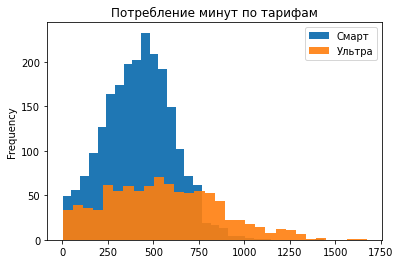

In [33]:
smart_revenue['duration'].plot(kind = 'hist', title = 'Потребление минут по тарифам', 
                               legend = True, label = 'Смарт', bins = 30)
ultra_revenue['duration'].plot(kind = 'hist', legend = True, label = 'Ультра', bins = 30, alpha = 0.9)

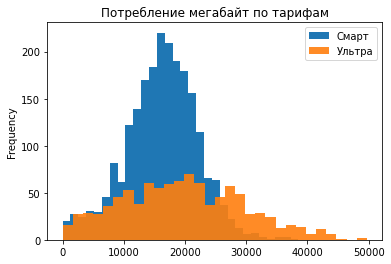

In [34]:
smart_revenue['mb_used'].plot(kind = 'hist', title = 'Потребление мегабайт по тарифам', 
                               legend = True, label = 'Смарт', bins = 30)
ultra_revenue['mb_used'].plot(kind = 'hist', legend = True, label = 'Ультра', bins = 30, alpha = 0.9)

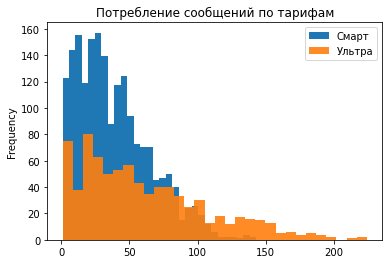

In [35]:
smart_revenue['messages_id'].plot(kind = 'hist', title = 'Потребление сообщений по тарифам', 
                               legend = True, label = 'Смарт', bins = 30)
ultra_revenue['messages_id'].plot(kind = 'hist', legend = True, label = 'Ультра', bins = 30, alpha = 0.9)

## Считаем дисперсию и стандартное отколнение для каждой из трех таблиц, сформированных выше

### Считаем дисперсию

In [36]:
def get_variance(column):
    new_variance = np.var(column, ddof = 1)
    return new_variance

Дисперсия для количества минут пользователей тарифа Смарт и Ультра соответственно

In [37]:
smart_revenue

,month,duration,calls_id,messages_id,mb_used,total_revenue
986,11.0,430.0,45.0,NaN,18405.0,1150.0
987,12.0,414.0,47.0,NaN,14018.0,550.0
988,6.0,117.0,14.0,4.0,10844.0,550.0
989,7.0,214.0,21.0,11.0,17557.0,1150.0
990,8.0,289.0,37.0,13.0,20298.0,1550.0
...,...,...,...,...,...,...
3211,9.0,NaN,NaN,32.0,17183.0,950.0
3212,10.0,NaN,NaN,21.0,19538.0,1550.0
3213,11.0,NaN,NaN,20.0,17471.0,1150.0
3214,12.0,NaN,NaN,35.0,17298.0,950.0


In [38]:
for i in [smart_revenue['duration'], ultra_revenue['duration']]:
    print(get_variance(i))

35718.128533936935
93338.4282914109


Дисперсия для количества мегабайт пользователей тарифа Смарт и Ультра соответственно

In [39]:
for i in [smart_revenue['mb_used'], ultra_revenue['mb_used']]:
    print(get_variance(i))

34277535.832490504
98684746.78807364


Дисперсия для количества сообщений пользователей тарифа Смарт и Ультра соответственно

In [40]:
for i in [smart_revenue['messages_id'], ultra_revenue['messages_id']]:
    print(get_variance(i))

717.5942011753527
2109.6591828652035


### Счиатем стандартное отклонение

Стандартное отклонение для количества минут пользователей тарифа Смарт и Ультра соответственно

In [41]:
for i in [smart_revenue['duration'], ultra_revenue['duration']]:
    print(np.sqrt(get_variance(i)))

188.9924033762652
305.513384799113


Стандартное отклонение для количества мегабайт пользователей тарифа Смарт и Ультра соответственно

In [42]:
for i in [smart_revenue['mb_used'], ultra_revenue['mb_used']]:
    print(np.sqrt(get_variance(i)))

5854.702027643294
9934.019669201065


Стандартное отклонение для количества сообщений пользователей тарифа Смарт и Ультра соответственно

In [43]:
for i in [smart_revenue['messages_id'], ultra_revenue['messages_id']]:
    print(np.sqrt(get_variance(i)))

26.787948804926305
45.931026364160466


**Вывод**

Было определено необходимое количество мегабайт, минут и смс для всех пользователей по месяцам.

Выведенные графики показали, что в течение последних 12 месяцев количество потребляемых минут, сообщений и мегабайтов растет, что означает, что люди потребляют все больше услуг компании.

Дисперсии, стандартные отклонения и гистограммы показали, что у пользователей тарифа Смарт потребление по всем категориям сгруппировано на небольшом отрезке, когда пользователи Ультра, наоборот, непредсказуемы, и зачастую тратят свой тариф не на максимум.

# Проверим гипотезы.

## Проверим гипотезу: Средняя выручка пользователей по тарифам различается

**Формируем нулевую гипотезу: Средняя выручка пользователей по тарифам равна**

**Формируем альтернативную гипотезу: Средняя выручка пользователей по тарифам отличается**

In [44]:
smart_revenue = user_revenue.query('tariff == "smart"')
smart_revenue = smart_revenue['total_revenue']
ultra_revenue = user_revenue.query('tariff == "ultra"')
ultra_revenue = ultra_revenue['total_revenue']

alpha = 0.05

result = st.ttest_ind(smart_revenue, ultra_revenue, equal_var = False)

if (result.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Отвергаем альтернативную гипотезу")

Отвергаем нулевую гипотезу


## Проверим, отличается ли средняя выручка пользователей по Москве от других регионов

**Формируем нулевую гипотезу: Средняя выручка пользователей по Москве равна выручке по другим регионам**

**Формируем альтернативную гипотезу: Средняя выручка пользователей по Москве не равна выручке по другим регионам**

In [45]:
moscow_revenue = user_revenue.query('city == "Москва"')
moscow_revenue = moscow_revenue['total_revenue']
regions_revenue = user_revenue.query('city != "Москва"')
regions_revenue = regions_revenue['total_revenue']

alpha = 0.05

result = st.ttest_ind(moscow_revenue, regions_revenue, equal_var = False)

if (result.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Отвергаем альтернативную гипотезу")
result

Отвергаем альтернативную гипотезу


Ttest_indResult(statistic=0.6533544384211365, pvalue=0.5136829862911095)

**Вывод**

На основе результатов проверки гипотез можно сделать вывод, что:

1) Средння выручка пользователей по тарифам не равна

2) Средняя выручка пользователей по Москве равна выручке по другим регионам.

## Посчитаем, сколько заработок от одного пользователя в среднем по каждому тарифу

In [46]:
smart_revenue

986     1150.0
987      550.0
988      550.0
989     1150.0
990     1550.0
         ...  
3211     950.0
3212    1550.0
3213    1150.0
3214     950.0
3215     550.0
Name: total_revenue, Length: 2230, dtype: float64

In [47]:
smart_revenue.sum() / smart_revenue.count()

1286.2336322869955

In [48]:
ultra_revenue.sum() / smart_revenue.count()

915.0

# Общий вывод по проекту.

**На основании данного проекта можно сделать выводы, что:**

**1) С каждым месяцем пользователи данных тарифов используют услуги все более активно.**

**2) Город пользователя не влияет на доход.**

**3) Тариф влияет на доход.**

**4) Сложно оценить прибыльность тарифом, не зная расходов компании по ним. Но можно сделать вывод, что тариф Смарт более перспективный, потому что среднепользовательский доход по нему выше.**